In [1]:
# supress warnings
import warnings 
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import tensorflow as tf
#import plotly.express as px
from tensorflow.keras import datasets, layers, models

In [3]:
## Load Data
data = pd.read_csv('age_gender.csv')
data = data.drop('img_name', axis=1)

## Strucure the image data as np 2d array
images = np.array(data['pixels'])
for i in range(len(images)):
    images[i] = np.array(images[i].split(' '),dtype = int)
images = np.array(images)
images = np.stack(np.array(images),axis=0)
images = np.reshape(images, (-1,48,48))
#images = images/255
data.drop('pixels',axis = 1)

#data.gender=data['gender'].astype('object')
#data.ethnicity=data['ethnicity'].astype('object')
#data.age = data['age'].astype('object')

,age,ethnicity,gender
0,1,2,0
1,1,2,0
2,1,2,0
3,1,2,0
4,1,2,0
...,...,...,...
23700,99,0,1
23701,99,1,1
23702,99,2,1
23703,99,2,1


In [4]:
from sklearn.utils import shuffle

images_gender_shu, gender_shu = shuffle(images, np.array(data['gender']))

In [5]:
print(images_gender_shu.shape)
print(gender_shu.shape)

(23705, 48, 48)
(23705,)


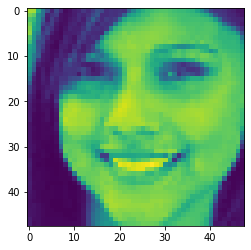

In [6]:
plt.imshow(images_gender_shu[1])

In [26]:
np.max(images_gender_shu[1])

226

In [10]:
img_width, img_height =48,48
img_channel = 1
img_shape = (img_width, img_height, img_channel)
num_classes = 2
z_dim = 100

## Build Generator

In [45]:
from keras.layers import UpSampling2D, Reshape, Activation, Conv2D, BatchNormalization, LeakyReLU, Input, Flatten, multiply
from keras.layers import Dense, Embedding
from keras.models import Sequential, Model

def build_generator():
    model = Sequential()
    model.add(Dense(128*12*12, activation = 'relu', input_shape = (z_dim, )))
    model.add(Reshape((12,12,128)))
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size = 3, padding = 'same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha = 0.02))
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size = 3, padding = 'same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha = 0.02))
    model.add(Conv2D(1, kernel_size = 3 , padding='same'))
    #model.add(Activation('relu'))
    
    z = Input(shape= (z_dim,))
    label = Input(shape=(1,), dtype = 'int32')
    
    label_embedding = Embedding(num_classes, z_dim, input_length = 1)(label)
    label_embedding = Flatten()(label_embedding)
    joined = multiply([z, label_embedding])
    
    img = model(joined)
    return Model([z, label], img)

generator = build_generator()
generator.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 1, 100)       200         input_30[0][0]                   
__________________________________________________________________________________________________
input_29 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
flatten_19 (Flatten)            (None, 100)          0           embedding_12[0][0]               
___________________________________________________________________________________________

In [46]:
from keras.layers import Dropout, Concatenate
import numpy as np

def build_discriminator():
    model = Sequential()
    model.add(Conv2D(32, kernel_size = 3, strides = 2, input_shape = (48,48,2), padding = 'same'))
    model.add(LeakyReLU(alpha = 0.02))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size = 3, strides = 2, input_shape = (48,48,2), padding = 'same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha = 0.02))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size = 3, strides = 2, input_shape = (48,48,2), padding = 'same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha = 0.02))
    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size = 3, strides = 2, input_shape = (48,48,2), padding = 'same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha = 0.02))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation = 'sigmoid'))
    
    img = Input(shape= (img_shape))
    label = Input(shape= (1,), dtype = 'int32')
    
    label_embedding = Embedding(input_dim = num_classes, output_dim = np.prod(img_shape), input_length = 1)(label)
    label_embedding = Flatten()(label_embedding)
    label_embedding = Reshape(img_shape)(label_embedding)
    
    concat = Concatenate(axis = -1)([img, label_embedding])
    prediction = model(concat)
    return Model([img, label], prediction)

discriminator = build_discriminator()
discriminator.summary()

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 1, 2304)      4608        input_32[0][0]                   
__________________________________________________________________________________________________
flatten_21 (Flatten)            (None, 2304)         0           embedding_13[0][0]               
__________________________________________________________________________________________________
input_31 (InputLayer)           (None, 48, 48, 1)    0                                            
___________________________________________________________________________________________

## Build Discriminator

In [47]:
from keras.layers import Dropout, Concatenate
import numpy as np

def build_discriminator():
    model = Sequential()
    model.add(Conv2D(32, kernel_size = 3, strides = 2, input_shape = (48,48,2), padding = 'same'))
    model.add(LeakyReLU(alpha = 0.02))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size = 3, strides = 2, input_shape = (48,48,2), padding = 'same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha = 0.02))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size = 3, strides = 2, input_shape = (48,48,2), padding = 'same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha = 0.02))
    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size = 3, strides = 2, input_shape = (48,48,2), padding = 'same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha = 0.02))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation = 'sigmoid'))
    
    img = Input(shape= (img_shape))
    label = Input(shape= (1,), dtype = 'int32')
    
    label_embedding = Embedding(input_dim = num_classes, output_dim = np.prod(img_shape), input_length = 1)(label)
    label_embedding = Flatten()(label_embedding)
    label_embedding = Reshape(img_shape)(label_embedding)
    
    concat = Concatenate(axis = -1)([img, label_embedding])
    prediction = model(concat)
    return Model([img, label], prediction)

discriminator = build_discriminator()
discriminator.summary()

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_34 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_14 (Embedding)        (None, 1, 2304)      4608        input_34[0][0]                   
__________________________________________________________________________________________________
flatten_23 (Flatten)            (None, 2304)         0           embedding_14[0][0]               
__________________________________________________________________________________________________
input_33 (InputLayer)           (None, 48, 48, 1)    0                                            
___________________________________________________________________________________________

## Compile and Join Model G/D

In [48]:
from keras.optimizers import Adam

discriminator.compile(loss = 'binary_crossentropy', optimizer = Adam(0.0002, 0.5), metrics = ['accuracy'])

z = Input(shape=(z_dim,))
label = Input(shape= (1,))
img = generator([z,label])

discriminator.trainable = False
prediction = discriminator([img, label])

cgan = Model([z, label], prediction)
cgan.compile(loss= 'mean_squared_error', optimizer = Adam(0.0002,0.5))

## Build a function for training G/D

In [49]:
def train(epochs, batch_size, save_interval):
    
    X_train = images_gender_shu
    y_train = gender_shu
    X_train = X_train/127.5 - 1
    X_train = np.expand_dims(X_train, axis=3)
    
    #(X_train,y_train),(X_test, y_test) = mnist.load_data()
    #X_train = X_train/127.5 - 1
    #X_train = np.expand_dims(X_train, axis=3)
    
    real = np.ones(shape= (batch_size, 1))
    fake = np.zeros(shape = (batch_size,1))
    
    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        img, labels = X_train[idx], y_train[idx]
        
        z = np.random.normal(0,1,size = (batch_size, z_dim))
        gen_img = generator.predict([z,labels])
        
        d_loss_real = discriminator.train_on_batch([img, labels], real)
        d_loss_fake = discriminator.train_on_batch([gen_img, labels], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        z = np.random.normal(0,1, size = (batch_size, z_dim))
        labels = np.random.randint(0, num_classes, batch_size).reshape(-1,1)
        
        g_loss = cgan.train_on_batch([z,labels], real)
        
        if epoch % save_interval == 0:
            print('{} [D_loss: {} , accuracy: {:.2f}] [G_loss: {}]'.format(epoch, d_loss[0], 100*d_loss[1], g_loss))
            save_image(epoch)

In [50]:
import matplotlib.pyplot as plt
def save_image(epoch):
    r, c = 2,5
    z = np.random.normal(0,1,(r*c, z_dim))
    labels = np.random.randint(0,2, r*c)
    #labels = np.arange(0,1).reshape(-1,1)
    gen_image = generator.predict([z,labels])
    gen_image = 0.5 * gen_image + 0.5
    
    fig, axes = plt.subplots(r,c, figsize = (10,10))
    count = 0
    for i in range(r):
        for j in range(c):
            axes[i,j].imshow(gen_image[count,:,:,0],cmap = 'gray')
            axes[i,j].axis('off')
            axes[i,j].set_title("Gender: %d" % labels[count])
            count+=1
    plt.savefig('images/Gender_04%d.jpg' % epoch)
    plt.close()

In [51]:
# train network
train(30000, 1, 500)

0 [D_loss: 0.8700032830238342 , accuracy: 50.00] [G_loss: 0.5723201036453247]
500 [D_loss: 0.23829534649848938 , accuracy: 100.00] [G_loss: 0.09489163011312485]
1000 [D_loss: 0.9415525794029236 , accuracy: 50.00] [G_loss: 0.23323573172092438]
1500 [D_loss: 0.015927717089653015 , accuracy: 100.00] [G_loss: 0.5747755169868469]
2000 [D_loss: 0.25787267088890076 , accuracy: 100.00] [G_loss: 0.013258527964353561]
2500 [D_loss: 0.3112514615058899 , accuracy: 100.00] [G_loss: 0.034616462886333466]
3000 [D_loss: 0.002238818211480975 , accuracy: 100.00] [G_loss: 0.002190849743783474]
3500 [D_loss: 0.9452890753746033 , accuracy: 50.00] [G_loss: 0.5763493776321411]
4000 [D_loss: 0.23021897673606873 , accuracy: 100.00] [G_loss: 0.16099080443382263]
4500 [D_loss: 0.38145849108695984 , accuracy: 50.00] [G_loss: 0.6285558342933655]
5000 [D_loss: 0.1070651188492775 , accuracy: 100.00] [G_loss: 0.006771221291273832]
5500 [D_loss: 0.1759611815214157 , accuracy: 100.00] [G_loss: 0.8037551045417786]
6000 